In [1]:
import pandas as pd
import numpy as np

In [116]:
#Load datasets
df = pd.read_csv('billboard_lyrics_1964-2015.csv', encoding = 'ISO-8859-1')

def clean_data(df):
    df = df.replace({'\n': ' '}, regex=True)
    df.dropna()
    
    df['word_count'] = df['Lyrics'].str.split().str.len()
    df = df[df['word_count'] != 1]
    df = df[df['word_count'] >= 100]
    df = df[df['word_count'] <= 1000] 
    df = df[df['Year'] >= 2015]
    df = df[df['Rank'] <= 10]
    #df = df.sample(n=25, random_state=1) 
    return df

#Now this is good data...
df=clean_data(df)
df.head(5)

,Rank,Song,Artist,Year,Lyrics,Source,word_count
5000,1,uptown funk,mark ronson featuring bruno mars,2015,this hit that ice cold michelle pfeiffer that...,1.0,566.0
5001,2,thinking out loud,ed sheeran,2015,when your legs dont work like they used to be...,1.0,319.0
5002,3,see you again,wiz khalifa featuring charlie puth,2015,its been a long day without you my friend and...,1.0,486.0
5003,4,trap queen,fetty wap,2015,im like hey wassup hello seen yo pretty ass s...,1.0,550.0
5004,5,sugar,maroon 5,2015,im hurting baby im broken down i need your lo...,1.0,442.0


We now get the lyrics as a seperate dataframe and preprocess the text.

In [117]:
import spacy

# Import only relevant modules 
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner"])

# Tokenization, stop word removal, and lemmatization.
def preprocess(text):
    doc = nlp(text)
    output = []
    for token in doc:
        if not token.is_stop and token.text:
            if token.text.isalpha() and len(token) > 2 and len(token) < 10:
                output.append(token.text)
    return output

def preprocess_lyrics(df):
    documents=[]
    for row in df.itertuples():
        lyric=row[5]
        documents.append(preprocess(str(lyric)))
    return documents
        
hit_documents=preprocess_lyrics(df)

print(hit_documents[:3])

[['hit', 'ice', 'cold', 'michelle', 'pfeiffer', 'white', 'gold', 'hood', 'girls', 'good', 'girls', 'straight', 'stylin', 'whilen', 'livin', 'city', 'got', 'chucks', 'saint', 'laurent', 'got', 'kiss', 'prettyim', 'hot', 'hot', 'damn', 'called', 'police', 'fireman', 'hot', 'hot', 'damn', 'dragon', 'wanna', 'retire', 'man', 'hot', 'hot', 'damn', 'know', 'hot', 'hot', 'damn', 'bad', 'bout', 'money', 'break', 'downgirls', 'hit', 'whoo', 'girls', 'hit', 'whoo', 'girls', 'hit', 'whoo', 'cause', 'uptown', 'funk', 'gon', 'cause', 'uptown', 'funk', 'gon', 'cause', 'uptown', 'funk', 'gon', 'saturday', 'night', 'spot', 'believe', 'watch', 'come', 'ondont', 'believe', 'watch', 'uhdont', 'believe', 'watch', 'believe', 'watch', 'believe', 'watch', 'believe', 'watch', 'hey', 'hey', 'hey', 'meaning', 'byamandah', 'editor', 'girl', 'group', 'sequence', 'accused', 'bruno', 'mars', 'producer', 'mark', 'ronson', 'ripping', 'sound', 'uptown', 'funk', 'song', 'question', 'funk', 'stop', 'wait', 'minute', 'fi

We now visualize the dataset after cleaning:

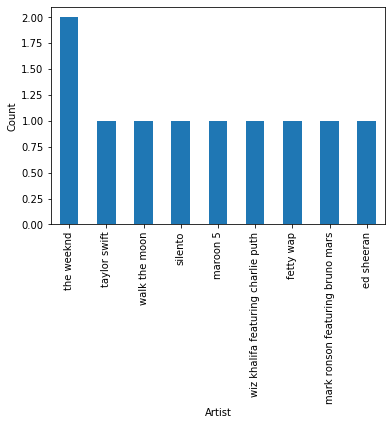

,Rank,Song,Artist,Year,Lyrics,Source,word_count
5002,3,see you again,wiz khalifa featuring charlie puth,2015,its been a long day without you my friend and...,1.0,486.0
5006,7,blank space,taylor swift,2015,nice to meet you where you been i could show ...,1.0,515.0
5007,8,watch me,silento,2015,now watch me whip kill it now watch me nae na...,1.0,407.0
5008,9,earned it,the weeknd,2015,you make it look like its magic cause i see n...,1.0,297.0
5000,1,uptown funk,mark ronson featuring bruno mars,2015,this hit that ice cold michelle pfeiffer that...,1.0,566.0
5003,4,trap queen,fetty wap,2015,im like hey wassup hello seen yo pretty ass s...,1.0,550.0
5005,6,shut up and dance,walk the moon,2015,oh dont you dare look back just keep your eye...,1.0,341.0
5009,10,the hills,the weeknd,2015,your man on the road he doin promo you said k...,1.0,471.0
5001,2,thinking out loud,ed sheeran,2015,when your legs dont work like they used to be...,1.0,319.0
5004,5,sugar,maroon 5,2015,im hurting baby im broken down i need your lo...,1.0,442.0


In [118]:
import matplotlib.pyplot as plt

artist_count = df['Artist'].value_counts().head(10)
year_count = df['Year'].value_counts().head(12)

artist_count.plot.bar()
plt.xlabel('Artist')
plt.ylabel('Count')
plt.show()

#year_count.plot.bar()
#plt.xlabel('Year')
#plt.ylabel('Count')
#plt.show()

df.sample(n=10)

Then, write code to train an [LdaModel] for $k=10$ topics, and using default values for all other parameters.
This is the topic model that each of the songs will need to be compared against.

In [101]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary

#Set number of topics
n=4

# Create a dictionary representation of the documents.
dictionary = Dictionary(hit_documents)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=len(hit_documents)/2, no_above=0.5)

# Bag-of-words representation of the documents.
hit_corpus = [dictionary.doc2bow(doc) for doc in hit_documents]

print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(hit_corpus))

# Make a index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary. dont work w/o it temp is black magic
id2word = dictionary.id2token

hit_model = LdaModel(
    corpus=hit_corpus,
    id2word=id2word,
    num_topics=n
    )

hit_model.print_topics()

Number of unique tokens: 9
Number of documents: 10


[(0,
  '0.290*"got" + 0.178*"ill" + 0.153*"way" + 0.146*"want" + 0.070*"like" + 0.047*"look" + 0.042*"editor" + 0.041*"meaning" + 0.033*"girl"'),
 (1,
  '0.566*"girl" + 0.268*"way" + 0.054*"look" + 0.054*"like" + 0.012*"got" + 0.012*"ill" + 0.012*"want" + 0.011*"meaning" + 0.011*"editor"'),
 (2,
  '0.223*"got" + 0.193*"ill" + 0.115*"like" + 0.110*"meaning" + 0.108*"editor" + 0.091*"girl" + 0.079*"want" + 0.059*"look" + 0.023*"way"'),
 (3,
  '0.506*"look" + 0.122*"way" + 0.121*"ill" + 0.121*"like" + 0.027*"want" + 0.027*"got" + 0.026*"girl" + 0.025*"editor" + 0.025*"meaning"')]

Check topic contribution to each document.

In [102]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=hit_model, corpus=hit_corpus, texts=hit_documents)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.8653,"got, ill, like, meaning, editor, girl, want, l...","[hit, ice, cold, michelle, pfeiffer, white, go..."
1,1,0.0,0.7998,"got, ill, way, want, like, look, editor, meani...","[legs, work, like, sweep, feet, mouth, remembe..."
2,2,0.0,0.9579,"got, ill, way, want, like, look, editor, meani...","[long, day, friend, ill, tell, come, long, way..."
3,3,2.0,0.5651,"got, ill, like, meaning, editor, girl, want, l...","[like, hey, wassup, hello, seen, pretty, ass, ..."
4,4,0.0,0.8597,"got, ill, way, want, like, look, editor, meani...","[hurting, baby, broken, need, loving, loving, ..."
5,5,3.0,0.8744,"look, way, ill, like, want, got, girl, editor,...","[dare, look, eyes, said, holding, said, shut, ..."
6,6,0.0,0.9717,"got, ill, way, want, like, look, editor, meani...","[nice, meet, things, magic, madness, heaven, s..."
7,7,0.0,0.8104,"got, ill, way, want, like, look, editor, meani...","[watch, whip, kill, watch, nae, nae, okay, wat..."
8,8,1.0,0.9647,"girl, way, look, like, got, ill, want, meaning...","[look, like, magic, cause, confused, hey, heyi..."
9,9,2.0,0.9169,"got, ill, like, meaning, editor, girl, want, l...","[man, road, doin, promo, said, business, lowlo..."


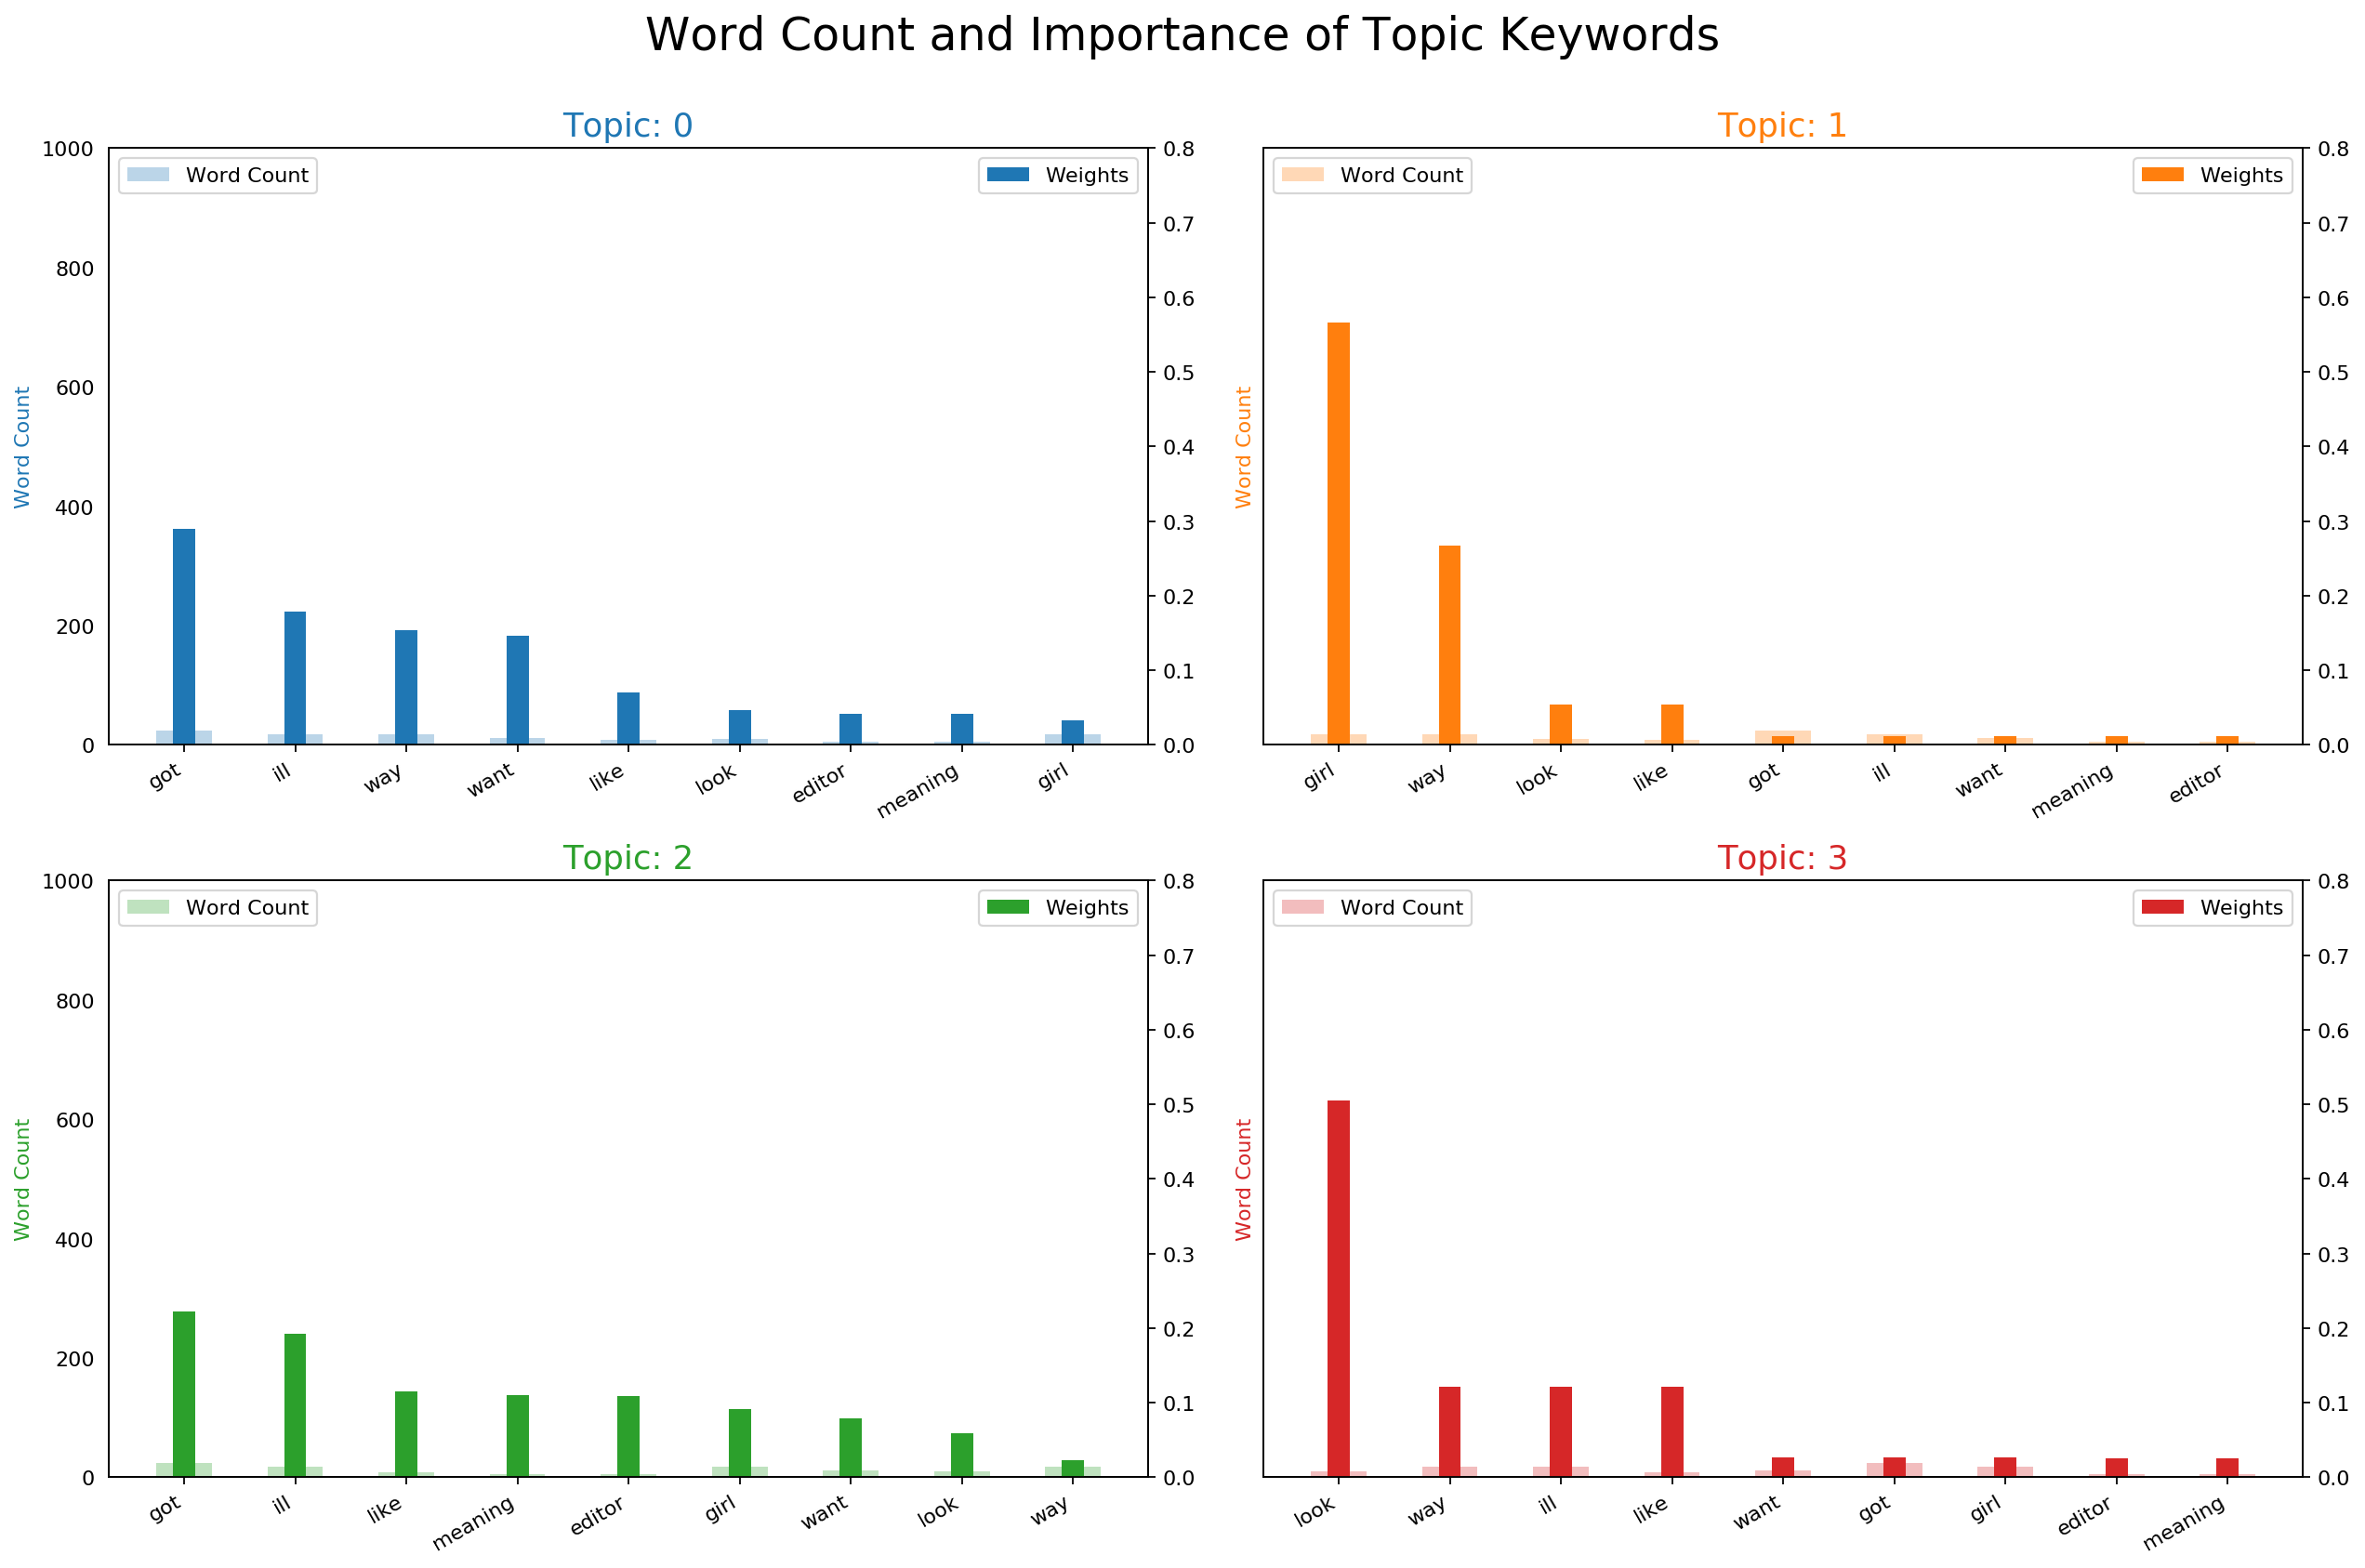

In [119]:
from collections import Counter
import matplotlib.colors as mcolors

topics = hit_model.show_topics(formatted=False)
data_flat = [w for w_list in hit_documents for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.8); ax.set_ylim(0, 1000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

Compare topic models for all songs lyrics. Wasserstein distance is used to calculate "hit-score" for each song.

In [122]:
from scipy.stats import wasserstein_distance
from scipy.spatial import distance

#Vectorize topics from the model
topic_vecs = []
for hit in hit_corpus:
    top_topics = hit_model.get_document_topics(hit, minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(4)]
    topic_vecs.append(topic_vec)


# Get wasserstein similarity (EMD)
EMD_similarity=[]
for x in topic_vecs:
    similarities=[]
    for y in topic_vecs:
        similarities.append(1-wasserstein_distance(x, y))
    EMD_similarity.append(similarities)

np.set_printoptions(precision=3)
print(np.asarray(EMD_similarity))
print(np.asarray(EMD_similarity).shape)
    
# Get cosine similarity
cosine_similarity=[]
for x in topic_vecs:
    similarities=[]
    for y in topic_vecs:
        similarities.append(1-distance.cosine(x, y))
    cosine_similarity.append(similarities)

np.set_printoptions(precision=3)
print(np.asarray(cosine_similarity))
print(np.asarray(cosine_similarity).shape)

# 1) Problem: Does Wasserstein distance work correctly here? Why are the values so far off from cosine 
# similarity?

# 2) Idea: Can you compare similarity measures to topic distribution? 
# Eg. EMD seems to work better than cosine similarity (or vice versa) on this dataset
# for x nr. of topics?

# Should I then compare EMD to cosine similarity for different nr. of topics and more documents?
# Eg. could use topic size t=5,10,30 and a fixed nr. of documents of 100? 
# Another way is to use parameter tuning to find appropriate nr. of topics for the model.
# Problem: This makes the matrices difficult to interpret. How can I compare these values when there is no
# "ground truth"? Could possibly compare to graphs and topic contribution percentage of each document.

# 3) Idea: Is it interesting to discuss the documents that are closest in similarity? 
# Eg. document 1 with Lyrics from Kanye West are similar to Drake? The corresponding artist should
# not be that difficult to find for a lyric-document in the o.g. dataset.


[[1.    0.967 0.954 0.809 0.98  0.995 0.947 0.973 0.95  0.974]
 [0.967 1.    0.921 0.818 0.959 0.963 0.914 0.995 0.918 0.941]
 [0.954 0.921 1.    0.789 0.951 0.958 0.993 0.926 0.997 0.979]
 [0.809 0.818 0.789 1.    0.829 0.806 0.782 0.817 0.785 0.799]
 [0.98  0.959 0.951 0.829 1.    0.977 0.944 0.963 0.948 0.97 ]
 [0.995 0.963 0.958 0.806 0.977 1.    0.951 0.968 0.955 0.979]
 [0.947 0.914 0.993 0.782 0.944 0.951 1.    0.919 0.996 0.973]
 [0.973 0.995 0.926 0.817 0.963 0.968 0.919 1.    0.923 0.947]
 [0.95  0.918 0.997 0.785 0.948 0.955 0.996 0.923 1.    0.976]
 [0.974 0.941 0.979 0.799 0.97  0.979 0.973 0.947 0.976 1.   ]]
(10, 10)
[[1.    0.142 0.067 0.81  0.088 0.101 0.061 0.137 0.069 0.999]
 [0.142 1.    0.993 0.689 0.997 0.137 0.992 1.    0.096 0.117]
 [0.067 0.993 1.    0.638 0.996 0.064 1.    0.994 0.027 0.045]
 [0.81  0.689 0.638 1.    0.65  0.093 0.634 0.686 0.042 0.797]
 [0.088 0.997 0.996 0.65  1.    0.083 0.995 0.997 0.115 0.063]
 [0.101 0.137 0.064 0.093 0.083 1.    0.058 0